In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

import msyexp.datasets as ds
import msyexp.general as general
import msyexp.plotfuncs as pf
import msyexp.xytools as xytools
import msyexp.diffexp as yd

%matplotlib inline

In [2]:
outdir = '{}/massspec'.format(ds.paths.NBOUTDIR)
if not os.path.exists(outdir):
    os.mkdir(outdir)

Load GTEx heart data

In [3]:
hdata = ds.get_gtex_data(males_only=False, adjusted=True, sum_mc_families=False)
hmeta = ds.get_metadata()
hmeta_ = hmeta.set_index('SAMPID')

hdata = hdata.loc[:, hmeta_.loc[hdata.columns, 'TISSUE']=='Heart - Left Ventricle']
print(hdata.shape)

(19759, 170)


Load mass spec data

In [4]:
dpep, dprot, pmeta = ds.get_mass_spec_data()

In [5]:
dpep.head()

,ProteinId,Description,GroupId,Class,SearchId,PeptideId,Redundancy,Unique/Razor,PeptideSequence,Collapsed?,...,rq_127a_sn,rq_127b_sn,rq_128a_sn,rq_128b_sn,rq_129a_sn,rq_129b_sn,rq_130a_sn,rq_130b_sn,rq_131a_sn,rq_131b_sn
1,ENSP00000000233,pep:known chromosome:GRCh37:5:150480666:150537...,1165,Set2,289693,11275,4,R,K.EMSGDVR.D,C,...,1007.716651,1367.073638,1591.046095,1299.422363,1552.082616,1500.946178,1622.195407,1594.076300,1563.454883,1483.137552
2,ENSP00000000233,pep:known chromosome:GRCh37:14:23881947:239034...,203,Set1,289686,9490,1,R,K.DVFVPDDK.Q,C,...,1049.728785,1426.502582,1346.595342,1443.168233,1288.235585,1379.610899,1390.283035,1546.482731,1477.268778,1497.190904
3,ENSP00000000233,pep:known chromosome:GRCh37:6:83920108:8414079...,2805,Set1,289678,4494,0,U,K.TATVYPEPQNK.E,C,...,1452.392548,1545.369784,1324.613423,1116.443055,1282.792374,1098.320486,1341.941570,1364.720540,1516.520040,1437.041320
4,ENSP00000000233,pep:known chromosome:GRCh37:12:6976283:6980112...,2357,Set1,289679,13562,1,R,R.HVFGESDELIGQK.V,C,...,1380.917309,1393.824328,1088.273646,789.340484,890.192593,1573.609507,1200.695800,1434.125588,1023.252052,1569.926062
5,ENSP00000000233,pep:known chromosome:GRCh37:5:80529104:8056221...,3457,Set3,289711,21381,3,R,R.LIDDHFLFDK.P,C,...,1090.224974,1435.023205,1538.951622,1044.503721,1326.087559,1506.818610,1417.118667,1110.442032,1167.031425,1114.890196


In [6]:
dprot.head()

,gene_name,group_id,set1_peptides,set2_peptides,set3_peptides,total_peptides,Set1~rq_126_sn_scaled,Set1~rq_127a_sn_scaled,Set1~rq_127b_sn_scaled,Set1~rq_128a_sn_scaled,...,Set3~rq_127a_sn_scaled,Set3~rq_127b_sn_scaled,Set3~rq_128a_sn_scaled,Set3~rq_128b_sn_scaled,Set3~rq_129a_sn_scaled,Set3~rq_129b_sn_scaled,Set3~rq_130a_sn_scaled,Set3~rq_130b_sn_scaled,Set3~rq_131a_sn_scaled,Set3~rq_131b_sn_scaled
protein_id,,,,,,,,,,,,,,,,,,,,,
sp|A0AVT1|UBA6_HUMAN,UBA6,1165,8,11,8,27,8.91838,8.94995,9.21245,8.96610,...,9.59959,8.85613,7.95495,8.71231,9.98684,8.32241,9.63201,10.73070,9.31577,8.55993
sp|A0FGR8-2|ESYT2_HUMAN,ESYT2,1246,9,10,11,30,9.67071,9.69186,8.22506,10.53170,...,8.33588,9.37875,8.71900,8.38809,9.44621,8.38034,9.95310,10.10040,9.92534,8.66303
sp|A0M8Q6|LAC7_HUMAN,IGLC7,295,12,7,14,33,5.22069,9.24773,8.87117,16.93320,...,7.30741,7.01629,6.51712,9.28722,9.95747,8.57503,10.70910,5.48256,15.69480,8.98227
sp|A0PJW6|TM223_HUMAN,TMEM223,2891,2,2,0,4,9.66626,9.45501,9.38523,8.71914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp|A1A4S6|RHG10_HUMAN,ARHGAP10,2183,7,6,1,14,8.79586,10.62160,9.25684,8.22925,...,9.86637,9.98527,7.89259,9.92733,6.48916,11.54670,7.40060,9.34984,8.17158,8.90782


In [7]:
pmeta.head()

,set_id,sample_id,sex,age,hypertension,bmi,sample_name,tag_id,sample_id2
0,Set1,1,M,54,0,22.71,1_M_54,rq_126_sn,M1_126
1,Set1,4,F,55,1,27.24,4_F_55,rq_127a_sn,F4_127a
2,Set1,5,F,58,1,29.02,5_F_58,rq_127b_sn,F5_127b
3,Set1,6,M,60,0,20.98,6_M_60,rq_128a_sn,M6_128a
4,Set1,12,M,56,1,21.95,12_M_56,rq_128b_sn,M12_128b


### Compare peptide detection to transcript abundance

In [8]:
# median expression level in TPM across all heart (LV) samples
heart_tpm = hdata.median(axis=1)
heart_tpm.head()

A1BG         0.473493
A1CF         0.022338
A2M        174.735638
A2ML1        0.145200
A3GALT2      0.034295
dtype: float64

In [9]:
n_peps = dprot[['gene_name', 'total_peptides']].groupby('gene_name').sum()['total_peptides']
n_peps

gene_name
A1BG       43
A2M       139
AACS        4
AAGAB       1
AAK1       35
         ... 
ZPR1        5
ZRANB2     14
ZW10        9
ZYX        32
ZZEF1      14
Name: total_peptides, Length: 5023, dtype: int64

In [10]:
df = pd.DataFrame({'TPM':heart_tpm, 
                   'n_peptides':n_peps.reindex(heart_tpm.index).fillna(0).astype(int)})
df['status'] = '0 peptides'
df.loc[df['n_peptides'] > 0, 'status'] = '>=1 peptide'

# add truncated log TPM for plotting
df['Log10(TPM)'] = df['TPM'].copy()
df.loc[df['Log10(TPM)'] < 0.1, 'Log10(TPM)'] = 0.1
df['Log10(TPM)'] = np.log10(df['Log10(TPM)'])
df

,TPM,n_peptides,status,Log10(TPM)
A1BG,0.473493,43,>=1 peptide,-0.324687
A1CF,0.022338,0,0 peptides,-1.000000
A2M,174.735638,139,>=1 peptide,2.242381
A2ML1,0.145200,0,0 peptides,-0.838034
A3GALT2,0.034295,0,0 peptides,-1.000000
...,...,...,...,...
ZYG11A,0.056030,0,0 peptides,-1.000000
ZYG11B,9.894791,0,0 peptides,0.995407
ZYX,50.574617,32,>=1 peptide,1.703933
ZZEF1,6.030875,14,>=1 peptide,0.780380


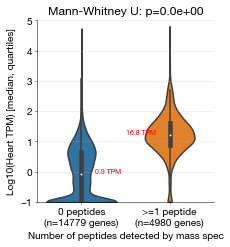

In [11]:
fig, ax = plt.subplots(figsize=(3.5,4))
fig.subplots_adjust(bottom=0.25, left=0.2)

ax = sns.violinplot(x='status', y='Log10(TPM)', data=df, 
                    order=['0 peptides', '>=1 peptide'],
                    cut=0)

##
counts = df['status'].value_counts()
ax.set_xticklabels(["0 peptides\n(n={} genes)".format(counts['0 peptides']),
                    ">=1 peptide\n(n={} genes)".format(counts['>=1 peptide'])])
ax.set_xlabel("Number of peptides detected by mass spec")
u, p = ss.mannwhitneyu(df.loc[df['status']=='0 peptides', 'TPM'],
                       df.loc[df['status']=='>=1 peptide', 'TPM'])
ax.set_title("Mann-Whitney U: p={:.1e}".format(p))
ax.set_ylabel("Log10(Heart TPM) [median, quartiles]")

med1 = df.loc[df['status']=='>=1 peptide', 'Log10(TPM)'].median()
med1_ = 10**med1
med0 = df.loc[df['status']=='0 peptides', 'Log10(TPM)'].median()
med0_ = 10**med0

ax.text(0.15, med0, '{:.1f} TPM'.format(med0_), color='r', size=7)
ax.text(0.5, med1, '{:.1f} TPM'.format(med1_), color='r', size=7)
##

ax.grid(axis='y', ls=':', color='0.7', lw=0.5)
ax.set_ylim([-1, 5])
ax = pf.format_spines(ax)

fig.savefig("{}/peptides_detected_vs_TPM.pdf".format(outdir))

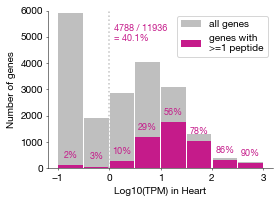

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))
fig.subplots_adjust(left=0.17, bottom=0.15, right=0.95)
log10tpm = df['Log10(TPM)'].copy()
log10tpm[log10tpm >= 3]=2.9
n0, _, _ = ax.hist(log10tpm, range=(-1, 3), bins=8, edgecolor='none', facecolor='0.75',
                   label='all genes', rwidth=0.95)

log10tpm_pep1 = df.loc[df.n_peptides>0, 'Log10(TPM)'].copy()
log10tpm_pep1[log10tpm_pep1 >= 3]=2.9
n1, _, _ = ax.hist(log10tpm_pep1, range=(-1, 3), bins=8, edgecolor='none', facecolor='#c51b8a', 
                   rwidth=0.95,
                   label='genes with\n>=1 peptide')

xs = np.arange(8)*0.5 - 0.75
percs = n1 / n0
for x, n1_, p in zip(xs, n1, percs):
    ax.text(x, n1_ + 200, "{:.0%}".format(p), color='#c51b8a', size=9,
            horizontalalignment='center', verticalalignment='bottom')

ax.set_ylabel('Number of genes')
ax.set_xlabel('Log10(TPM) in Heart')
ylim = [0, 6000]
ax.set_ylim(ylim)
ax.plot([0, 0], ylim, ls=':', color='0.76')

n0_g1 = int(np.sum(n0[2:]))
n1_g1 = int(np.sum(n1[2:]))
ax.text(0.1, 5500, '{0} / {1}\n= {2:.1%}'.format(n1_g1, n0_g1, n1_g1 / float(n0_g1)),
        size=9, color='#c51b8a', verticalalignment='top')

ax.legend()
ax = pf.format_spines(ax)

fig.savefig("{}/detected_peptides_by_TPM_histogram.pdf".format(outdir))

In [13]:
n_peps_full = n_peps.reindex(heart_tpm.index).fillna(0).astype(int)
n_peps_full

A1BG        43
A1CF         0
A2M        139
A2ML1        0
A3GALT2      0
          ... 
ZYG11A       0
ZYG11B       0
ZYX         32
ZZEF1       14
ZZZ3         0
Name: total_peptides, Length: 19759, dtype: int64

In [14]:
n_tpm1_pep1 = ((heart_tpm >= 1) & (n_peps_full >= 1)).sum()
n_tpm1_pep0 = ((heart_tpm >= 1) & (n_peps_full < 1)).sum()
n_tpm0_pep1 = ((heart_tpm < 1) & (n_peps_full >= 1)).sum()
n_tpm0_pep0 = ((heart_tpm < 1) & (n_peps_full < 1)).sum()
n_tpm1 = n_tpm1_pep0 + n_tpm1_pep1
n_tpm0 = n_tpm0_pep0 + n_tpm0_pep1

print("number of genes >1 TPM in the heart = {}".format(n_tpm1))
print("number of genes >1 TPM and >=1 peptide = {0} ({1:.1%} of >1 TPM genes)".format(n_tpm1_pep1, n_tpm1_pep1 / float(n_tpm1)))
print("\n7/18 X-Y pair genes detected = {:.1%}".format(7/18.))
OR, p = ss.fisher_exact([[11, 7],
                         [n_tpm1_pep0, n_tpm1_pep1]])
print("Fisher exact test (two-sided), p = {:.3f}".format(p))

print("\nnumber of genes <1 TPM in the heart = {}".format(n_tpm0))
print("number of genes <1 TPM and 0 peptides = {0} ({1:.1%} of <1 TPM genes)".format(n_tpm0_pep0, n_tpm1_pep0 / float(n_tpm0)))

number of genes >1 TPM in the heart = 11936
number of genes >1 TPM and >=1 peptide = 4788 (40.1% of >1 TPM genes)

7/18 X-Y pair genes detected = 38.9%
Fisher exact test (two-sided), p = 1.000

number of genes <1 TPM in the heart = 7823
number of genes <1 TPM and 0 peptides = 7631 (91.4% of <1 TPM genes)


In [15]:
ss.fisher_exact([[11, 7],
                 [n_tpm1_pep0, n_tpm1_pep1]])

(1.0526021264689425, 1.0)

### Plot X–Y pair TPMs in the heart

### X-Y pairs

X-Y pair genes with at least one peptide detected

In [16]:
xygenes = list(filter(lambda g: g in dprot['gene_name'].values, xytools.XYPAIRS_X9+xytools.XYPAIRS_Y9))
print(xygenes)

['DDX3X', 'EIF1AX', 'RPS4X', 'USP9X', 'DDX3Y', 'EIF1AY', 'RPS4Y1']


Find all proteins in that share a peptide with one of the above proteins using the group ID

In [17]:
xygroups = dprot.loc[dprot['gene_name'].isin(xygenes), 'group_id'].unique()
for g in xygroups:
    _genes = dprot.loc[dprot.group_id==g, 'gene_name'].unique()
    print("group_id={0}: {1}".format(g, str(list(_genes))))

group_id=1028: ['DDX3X', 'DDX3Y', 'DDX5', 'DDX17']
group_id=2074: ['EIF1AY', 'EIF1AX']
group_id=2338: ['RPS4Y1', 'RPS4X']
group_id=1116: ['USP9X']


Extract signal/noise values for peptides

In [18]:
rqcols = list(filter(lambda c: c.startswith('rq'), dpep.columns))
pdata = dpep[['Class', 'PeptideSequence']+rqcols]
_pdata = {}
for s in ('Set1', 'Set2', 'Set3'):
    p_s = pdata.loc[pdata['Class']==s]
    _ = p_s.pop('Class')
    _pdata[s] = p_s.groupby('PeptideSequence').sum()
pdata = pd.concat(_pdata, axis=1, sort=True)
pdata

Set1                                      \
                          rq_126_sn  rq_127a_sn  rq_127b_sn  rq_128a_sn   
-.AAEAVATGAK.E           264.257159  320.725048  133.267597  131.330080   
-.EVQLVESGGGLVQPGGSLR.L   49.535508  109.761359  120.823662  145.437252   
-.FSGFTQK.L              211.842530  344.062754  409.403855  243.540665   
-.IYPIMDK.S                     NaN         NaN         NaN         NaN   
-.LASDEITTVR.K            32.975275   61.349546   33.661286   36.254977   
...                             ...         ...         ...         ...   
R.YYTSASGDEMVSLK.D       434.948184  314.802987  348.686886  307.104900   
R.YYTVFDR.D              523.971390  630.328618  330.805544  554.980242   
R.YYTYLIMNK.G             88.352175  158.657095  120.758624  305.446145   
R.YYWGGQYTWDM*AK.H              NaN         NaN         NaN         NaN   
R.YYWGGQYTWDMAK.H         86.856129  109.536456   85.548100  136.016812   

                                                                         \
                         rq_128b_sn  rq_129a_sn  rq_129b_sn  rq_130a_sn   
-.AAEAVATGAK.E           123.518767   73.027203  128.843564  228.288052   
-.EVQLVESGGGLVQPGGSLR.L  124.992963   57.724655   69.591432   57.666494   
-.FSGFTQK.L              253.247120  240.739713  334.017246  294.526615   
-.IYPIMDK.S                     NaN         NaN         NaN         NaN   
-.LASDEITTVR.K            26.812492   26.080662   37.987963   38.628384   
...                             ...         ...         ...         ...   
R.YYTSASGDEMVSLK.D       198.908279  280.033771  593.353478  523.259879   
R.YYTVFDR.D              298.008723  261.210315  412.501529  382.854746   
R.YYTYLIMNK.G            151.154886  126.605738  149.735236  263.896619   
R.YYWGGQYTWDM*AK.H              NaN         NaN         NaN         NaN   
R.YYWGGQYTWDMAK.H         68.896986  117.690447  114.390852  147.367769   

                                                 ...        Set3              \
                         rq_130b_sn  rq_131a_sn  ...  rq_127a_sn  rq_127b_sn   
-.AAEAVATGAK.E           288.742364  382.693354  ...  196.393728  150.164986   
-.EVQLVESGGGLVQPGGSLR.L   58.332347   54.133258  ...  236.675131  249.196343   
-.FSGFTQK.L              377.462426  367.163820  ...  243.058914  236.834304   
-.IYPIMDK.S                     NaN         NaN  ...  141.111560   93.770137   
-.LASDEITTVR.K            43.550296   46.625724  ...         NaN         NaN   
...                             ...         ...  ...         ...         ...   
R.YYTSASGDEMVSLK.D       313.385514  345.133854  ...  386.031631  425.458543   
R.YYTVFDR.D              486.207414  203.382076  ...  190.727788  143.281909   
R.YYTYLIMNK.G             98.416524  104.452489  ...  109.105175  116.674064   
R.YYWGGQYTWDM*AK.H              NaN         NaN  ...   23.998649   32.353036   
R.YYWGGQYTWDMAK.H         28.983945   92.244986  ...   81.201440  137.589028   

                                                                         \
                         rq_128a_sn  rq_128b_sn  rq_129a_sn  rq_129b_sn   
-.AAEAVATGAK.E           140.220416  118.883396  405.099622  278.048058   
-.EVQLVESGGGLVQPGGSLR.L  136.585182  172.004853  187.731108  284.081040   
-.FSGFTQK.L              197.835253  160.535408  177.837588  189.324314   
-.IYPIMDK.S              110.507757  130.585316  120.983469  113.235084   
-.LASDEITTVR.K                  NaN         NaN         NaN         NaN   
...                             ...         ...         ...         ...   
R.YYTSASGDEMVSLK.D       153.592659  339.848652  475.077759  559.644385   
R.YYTVFDR.D              189.766039  142.718900  103.409819  222.148946   
R.YYTYLIMNK.G             57.164359   94.108498   89.685039   56.692811   
R.YYWGGQYTWDM*AK.H       119.661120   24.155088   49.097662   37.652997   
R.YYWGGQYTWDMAK.H         23.911204   76.269117  145.292701  118.476244   

                                                              

Column normalize signal/noise data

In [19]:
pdata = pdata / pdata.sum(axis=0) * 1e6
pdata1 = pdata.copy()  # saved at level of column normalized peptides

Read in protein sequences for X-Y pair proteins

In [22]:
with open(ds.paths.UNIPROT_XYSEQS) as f:
    text = f.read().lstrip('>')
entries = text.split('>')

prot_seqs = {}
p_counts = {}
for en in entries:
    header, rest = en.split('\n', 1)
    items = header.split(' ')
    for it in items:
        if it.startswith('GN'):
            gene = it.split('=')[1]
            p_counts[gene] = p_counts.setdefault(gene, 0) + 1
            gene = '{0}_{1}'.format(gene, p_counts[gene])
    seq = rest.replace('\n', '')
    prot_seqs[gene] = seq
    
print(len(prot_seqs))
print(prot_seqs.keys())

17
dict_keys(['DDX3Y_1', 'DDX3Y_2', 'DDX3Y_3', 'DDX3X_1', 'DDX3X_2', 'USP9X_1', 'USP9X_2', 'RPS4X_1', 'RPS4Y1_1', 'EIF1AX_1', 'EIF1AY_1', 'DDX5_1', 'DDX5_2', 'DDX17_1', 'DDX17_2', 'DDX17_3', 'DDX17_4'])


Find peptides that match the XY pair sequences

In [23]:
pdata = pdata1.copy()

matches = []
matches_nonnull = []
xypeps = []
i = 0
cts = 0
for pep, row in pdata.iterrows():
    _match = set([])
    seq = pep.replace('.', '').strip('-').replace('*', '')
    pat = re.compile(seq)
    for g in prot_seqs:
        if pat.search(prot_seqs[g]):
            _match.add(g.split('_')[0])
            cts += 1
    if len(_match) == 0:
        matches.append(np.nan)
    else:
        _match = list(_match)
        _match.sort()
        matches.append(','.join(_match))
        matches_nonnull.append(','.join(_match))
        xypeps.append(pep)
    i += 1
    if i % 5000 == 0:
        general._print("{} lines...".format(i))
        
pdata['matched_proteins'] = matches

5000 lines...
10000 lines...
15000 lines...
20000 lines...
25000 lines...
30000 lines...
35000 lines...
40000 lines...
45000 lines...
50000 lines...


Subset data to just peptides that matched

In [24]:
pdata = pdata.loc[pdata.matched_proteins.notnull()]
pdata['matched_proteins'].value_counts()

USP9X            33
DDX3X,DDX3Y      16
DDX5             14
DDX17            13
DDX3X            11
DDX17,DDX5        8
RPS4X             8
RPS4X,RPS4Y1      5
DDX3Y             4
EIF1AX,EIF1AY     3
EIF1AX            1
EIF1AY            1
RPS4Y1            1
Name: matched_proteins, dtype: int64

View sequences of peptdies that matched in an X-specific, Y-specific, or X-Y-shared manner, and the number of sets (i.e., 11-plex experiments, out of 3 total) in which each peptide was detected

In [25]:
pep_counts = []
for p in ('DDX3X', 'DDX3Y', 'DDX3X,DDX3Y',
          'EIF1AX', 'EIF1AY', 'EIF1AX,EIF1AY',
          'RPS4X', 'RPS4Y1', 'RPS4X,RPS4Y1'):
    cts_p = pdata.loc[pdata.matched_proteins==p, (slice(None), 'rq_126_sn')].notnull().sum(axis=1)
    cts_p = pd.DataFrame({'n_sets':cts_p})
    cts_p['matched_proteins'] = p
    pep_counts.append(cts_p)
pep_counts = pd.concat(pep_counts, axis=0)
pep_counts.index.name = 'peptide_seq'
pep_counts = pep_counts.reset_index().reindex(['peptide_seq', 'matched_proteins', 'n_sets'],
                                              axis=1)
pep_counts

,peptide_seq,matched_proteins,n_sets
0,K.DAYSSFGSR.S,DDX3X,2
1,K.DSLTLVFVETK.K,DDX3X,2
2,K.DSSGWSSSK.D,DDX3X,2
3,K.HAIPIIK.E,DDX3X,3
4,K.HVINFDLPSDIEEYVHR.I,DDX3X,1
5,K.SDEDDWSK.P,DDX3X,3
6,K.VVWVEESDK.R,DDX3X,3
7,K.VVWVEESDKR.S,DDX3X,1
8,R.GLDISNVK.H,DDX3X,2
9,R.SDYDGIGSR.G,DDX3X,1


#### Examine specificity of putative Y-specific peptides

In [26]:
ydata = pdata.loc[pdata.matched_proteins.isin(xytools.XYPAIRS_Y9)]
ydata.index.name = 'peptide_seq'
ydata

Set1                                              \
                    rq_126_sn rq_127a_sn rq_127b_sn rq_128a_sn rq_128b_sn   
peptide_seq                                                                 
K.SVEDDWSK.P        27.895803   0.439201   1.487937  27.262576  25.255019   
R.GLDISNVR.H              NaN        NaN        NaN        NaN        NaN   
R.LEALCFDGVK.R      14.781526   2.108257   1.884525  16.980070  16.482248   
R.LTVAEER.D         21.338631   0.983852   2.841155  20.997503  18.119217   
R.SDYDGIGNR.E             NaN        NaN        NaN        NaN        NaN   
R.VGNLGLATSFFNEK.N        NaN        NaN        NaN        NaN        NaN   

                                                                           \
                   rq_129a_sn rq_129b_sn rq_130a_sn rq_130b_sn rq_131a_sn   
peptide_seq                                                                 
K.SVEDDWSK.P        32.876227   2.489920   2.380389  24.908620  27.045977   
R.GLDISNVR.H              NaN        NaN        NaN        NaN        NaN   
R.LEALCFDGVK.R      14.968095   2.711304   1.944108  11.162483   9.682957   
R.LTVAEER.D         24.866473   2.054129   1.906194  22.690135  22.932677   
R.SDYDGIGNR.E             NaN        NaN        NaN        NaN        NaN   
R.VGNLGLATSFFNEK.N        NaN        NaN        NaN        NaN        NaN   

                    ...       Set3                                   \
                    ... rq_127b_sn rq_128a_sn rq_128b_sn rq_129a_sn   
peptide_seq         ...                                               
K.SVEDDWSK.P        ...        NaN        NaN        NaN        NaN   
R.GLDISNVR.H        ...        NaN        NaN        NaN        NaN   
R.LEALCFDGVK.R      ...  14.494402  11.047913  11.033512   8.058950   
R.LTVAEER.D         ...        NaN        NaN        NaN        NaN   
R.SDYDGIGNR.E       ...  18.098540  18.185290  18.688292  19.061086   
R.VGNLGLATSFFNEK.N  ...   2.841347   3.085460   2.583808   1.715072   

                                                                           \
                   rq_129b_sn rq_130a_sn rq_130b_sn rq_131a_sn rq_131b_sn   
peptide_seq                                                                 
K.SVEDDWSK.P              NaN        NaN        NaN        NaN        NaN   
R.GLDISNVR.H              NaN        NaN        NaN        NaN        NaN   
R.LEALCFDGVK.R       2.800676   2.353828  10.262773  10.838980  11.816394   
R.LTVAEER.D               NaN        NaN        NaN        NaN        NaN   
R.SDYDGIGNR.E        2.149953   2.154641  16.399928  17.434916  20.252236   
R.VGNLGLATSFFNEK.N   0.372551   0.746271   1.975978   1.670713   2.863036   

                   matched_proteins  
                                     
peptide_seq                          
K.SVEDDWSK.P                  DDX3Y  
R.GLDISNVR.H                  DDX3Y  
R.LEALCFDGVK.R               EIF1AY  
R.LTVAEER.D                  RPS4Y1  
R.SDYDGIGNR.E                 DDX3Y  
R.VGNLGLATSFFNEK.N            DDX3Y  

[6 rows x 34 columns]

Reformat data for plotting

In [27]:
vname = 'signal/noise'
ydf = pd.melt(ydata.reset_index(), id_vars=['peptide_seq', 'matched_proteins'], 
              var_name=['set_id', 'tag_id'],
              value_name=vname)
ydf = ydf.loc[ydf[vname].notnull()]

# add sex
ydf = pd.merge(ydf, pmeta[['set_id', 'tag_id', 'sex']], on=['set_id', 'tag_id'], how='left')

# create unique protein/peptide/set index
ydf['psid'] = ydf.matched_proteins.str.cat(ydf['peptide_seq'], sep='_').str.cat(ydf['set_id'], sep='_')
ydf

,peptide_seq,matched_proteins,set_id,tag_id,signal/noise,sex,psid
0,K.SVEDDWSK.P,DDX3Y,Set1,rq_126_sn,27.895803,M,DDX3Y_K.SVEDDWSK.P_Set1
1,R.LEALCFDGVK.R,EIF1AY,Set1,rq_126_sn,14.781526,M,EIF1AY_R.LEALCFDGVK.R_Set1
2,R.LTVAEER.D,RPS4Y1,Set1,rq_126_sn,21.338631,M,RPS4Y1_R.LTVAEER.D_Set1
3,K.SVEDDWSK.P,DDX3Y,Set1,rq_127a_sn,0.439201,F,DDX3Y_K.SVEDDWSK.P_Set1
4,R.LEALCFDGVK.R,EIF1AY,Set1,rq_127a_sn,2.108257,F,EIF1AY_R.LEALCFDGVK.R_Set1
...,...,...,...,...,...,...,...
83,R.SDYDGIGNR.E,DDX3Y,Set3,rq_131a_sn,17.434916,M,DDX3Y_R.SDYDGIGNR.E_Set3
84,R.VGNLGLATSFFNEK.N,DDX3Y,Set3,rq_131a_sn,1.670713,M,DDX3Y_R.VGNLGLATSFFNEK.N_Set3
85,R.LEALCFDGVK.R,EIF1AY,Set3,rq_131b_sn,11.816394,M,EIF1AY_R.LEALCFDGVK.R_Set3
86,R.SDYDGIGNR.E,DDX3Y,Set3,rq_131b_sn,20.252236,M,DDX3Y_R.SDYDGIGNR.E_Set3


Plot

Text(0.5, 0, '')

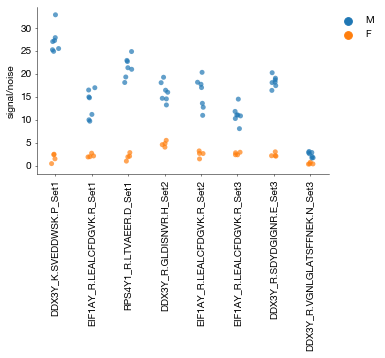

In [28]:
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.3, right=0.8)
ax = sns.stripplot(x='psid', y='signal/noise', hue='sex', data=ydf, alpha=0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

ax = pf.format_spines(ax)
ax = pf.rotate_ticklabels(ax, 'x')
ax.set_xlabel('')

Estimate background noise from Y peptides in female channels, excluding the final peptide

In [29]:
ydf_f = ydf.loc[ydf.sex.eq('F') & (~ydf.peptide_seq.eq('R.VGNLGLATSFFNEK.N'))]
fvals = ydf_f.groupby(['peptide_seq', 'set_id']).mean()
noise_mean = fvals.mean()[0]
noise_sd = fvals.std()[0]
print(noise_mean)
print(noise_sd)

2.568648370131527
1.0025452174067064


Plot showing background noise to be subtracted

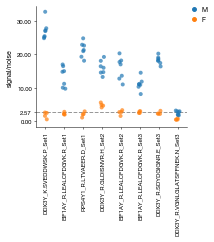

In [30]:
fig, ax = plt.subplots(figsize=(3, 3.5))
fig.subplots_adjust(bottom=0.47, right=0.87, left=0.17, top=0.95)
ax = sns.stripplot(x='psid', y='signal/noise', hue='sex', data=ydf,
                   s=4, alpha=0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False,
          borderpad=0, handletextpad=0, borderaxespad=0, markerscale=0.5,
          fontsize=7)

xlim = ax.get_xlim()
ax.set_xlim(xlim)
ax.plot(xlim, [noise_mean, noise_mean], ls='--', color='0.6', lw=1)

yticks = [0, np.round(noise_mean, 2), 10, 20, 30]
ax.set_yticks(yticks)

ax = pf.format_spines(ax)
ax = pf.rotate_ticklabels(ax, 'x')
ax.set_xlabel('')
ax = pf.format_axis_labels(ax)

fig.savefig("{}/Yspecific_peptides_in_males_females.pdf".format(outdir))

Check to make sure "background" (female) signal does not correlate with true (male) signal

Text(0.5, 1.0, 'Kendall tau=-0.143, p=0.720')

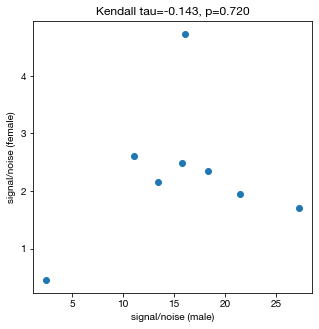

In [31]:
mfmean = ydf.groupby(['psid', 'sex']).mean()
mfmean = mfmean.unstack('sex')['signal/noise']

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(mfmean['M'], mfmean['F'])
ax.set_xlabel('signal/noise (male)')
ax.set_ylabel('signal/noise (female)')

t, p = ss.kendalltau(mfmean['M'], mfmean['F'])
ax.set_title("Kendall tau={0:.3f}, p={1:.3f}".format(t, p))

### Estimate ratios

In [32]:
def protein_quant(pdata, noise_mu=2.6, noise_std=0):
    """ Assemble peptide quantification into protein quantificaiton
    
    pdata : DataFrame
        peptide x (set, channel) data; last column is 'matched_proteins'
    noise_mu, noise_std : float
        mean and standard deviation for noise to subtract from background
    """
    gcol = 'matched_proteins'
    
    df = {}
    for s in ('Set1', 'Set2', 'Set3'):
        d = pdata[s]
        meta_ = pdata[gcol]
        
        if noise_mu > 0:
            noise = ss.norm.rvs(loc=noise_mu, scale=noise_std, size=d.shape)
            noise[noise < 0] = 0
            d = d - noise
            d[d < 0] = 0
        
        d = d.groupby(by=lambda p: meta_[p], axis=0).sum()
        d = d.divide(d.sum(axis=1), axis=0) * 100
        df[s] = d
    df = pd.concat(df, axis=1, sort=True)
    return df

In [33]:
pmeta.head()

,set_id,sample_id,sex,age,hypertension,bmi,sample_name,tag_id,sample_id2
0,Set1,1,M,54,0,22.71,1_M_54,rq_126_sn,M1_126
1,Set1,4,F,55,1,27.24,4_F_55,rq_127a_sn,F4_127a
2,Set1,5,F,58,1,29.02,5_F_58,rq_127b_sn,F5_127b
3,Set1,6,M,60,0,20.98,6_M_60,rq_128a_sn,M6_128a
4,Set1,12,M,56,1,21.95,12_M_56,rq_128b_sn,M12_128b


In [34]:
def calc_normalized_signal(rdata, meta, prot, use_median=False):
    """ Return long-form dataframe with normalized protein abundance for one protein
    
    rdata : DataFrame
        protein x (set, channel) DataFrame, e.g., as output by protein_quant
    meta : DataFrame
        contains set, sex, and channel information in `set_id`, `sex`, and
        `tag_id` columns, respectively
    prot : str
        the protein to return results for
    use_median : bool
        normalize to median in female samples (default: normalize to mean)
    """
    set_ids = ['Set1', 'Set2', 'Set3']
    val_name = 'Normalized intensity'
    df = []
    for s in set_ids:
        meta_ = meta.loc[meta.set_id==s].set_index('tag_id')
        df_s = rdata[s].copy()
        
        fvals = df_s.loc[prot, meta_.loc[df_s.columns, 'sex']=='F']
        f_m = fvals.median() if use_median else fvals.mean()
        
        d = pd.DataFrame({val_name:(df_s.loc[prot] / f_m),
                          'sex':meta_.loc[df_s.columns, 'sex']})
        d['set_id'] = s
        df.append(d)
        
    df = pd.concat(df, axis=0)
    df['sex'] = pd.Categorical(df['sex'], ['F', 'M'])
    df = df.loc[df['Normalized intensity'].notnull()]
    return df

In [35]:
def calc_normalized_signal_xy(rdata, meta, gx, gy, use_median=False):
    """ Return long-form dataframe with normalized protein abundance for one X-Y pair
    
    rdata : DataFrame
        protein x (set, channel) DataFrame, e.g., as output by protein_quant
    meta : DataFrame
        contains set, sex, and channel information in `set_id`, `sex`, and
        `tag_id` columns, respectively
    gx, gy : str
        X and Y homologs
    use_median : bool
        normalize to median in female samples (default: normalize to mean)
    """
    d_x = calc_normalized_signal(rdata, meta, gx, use_median=use_median)
    d_xy = calc_normalized_signal(rdata, meta, "{0},{1}".format(gx, gy),
                                  use_median=use_median)
    d_x['peptide_type'] = 'X-specific'
    d_xy['peptide_type'] = 'XY-shared'
    df = pd.concat([d_x, d_xy], axis=0, ignore_index=True)
    return df

In [36]:
df = protein_quant(pdata)

# remove peptides that also match DDX17, DDX5
df = df.loc[~df.index.str.contains('DDX17')]
df = df.loc[~df.index.str.contains('DDX5')]
df

Set1                                              \
               rq_126_sn rq_127a_sn rq_127b_sn rq_128a_sn rq_128b_sn   
DDX3X           8.583328   8.359840  10.723102   6.702849   6.433485   
DDX3X,DDX3Y     8.617633   8.852539   9.660022   7.710138   7.500544   
DDX3Y          14.658723   0.000000   0.000000  14.291773  13.128409   
EIF1AX          7.846035   8.586330  12.734965   6.567806   7.292971   
EIF1AX,EIF1AY  10.917781   3.798175   4.880804  11.963389   8.420110   
EIF1AY         16.038806   0.000000   0.000000  18.933519  18.278061   
RPS4X           9.179243   9.693538   9.007138   8.774845   6.735623   
RPS4X,RPS4Y1    9.717085   8.280864   9.133624   8.397816   5.747916   
RPS4Y1         14.163135   0.000000   0.182271  13.905302  11.729820   
USP9X           9.269836   9.050831   9.706736   8.532389   8.087054   

                                                                      ...  \
              rq_129a_sn rq_129b_sn rq_130a_sn rq_130b_sn rq_131a_sn  ...   
DDX3X           9.699255  13.763314  13.211366   7.738364   7.499524  ...   
DDX3X,DDX3Y     9.762015  11.731987  11.012071   9.123914   8.264824  ...   
DDX3Y          17.544841   0.000000   0.000000  12.927674  14.166256  ...   
EIF1AX          7.566549  21.538743  14.217917   5.894228   3.489359  ...   
EIF1AX,EIF1AY  11.868974   9.773840   8.980431   9.095546   9.507819  ...   
EIF1AY         16.284453   0.146548   0.000000  11.273793   9.325775  ...   
RPS4X           8.958617  11.464779  11.880167   7.859042   9.090862  ...   
RPS4X,RPS4Y1    8.652327  11.853283  11.261453   9.407504   8.675815  ...   
RPS4Y1         16.829567   0.000000   0.000000  15.184636  15.367955  ...   
USP9X           8.853185   9.100158   9.043061   9.121305   9.961080  ...   

                    Set3                                              \
              rq_127a_sn rq_127b_sn rq_128a_sn rq_128b_sn rq_129a_sn   
DDX3X          12.263480   8.377336   7.729608   8.676621   8.611459   
DDX3X,DDX3Y    10.814940   8.490081   5.909277   9.614774   9.965261   
DDX3Y           0.367189  14.139458  14.436680  14.452438  14.787326   
EIF1AX         14.916481  11.205575   4.545625  10.024662   4.816878   
EIF1AX,EIF1AY   5.119915  10.009106  10.151378  10.486296  11.040472   
EIF1AY          0.000000  19.867093  14.110460  14.086406   9.118026   
RPS4X           9.777023   7.525335   8.332066   8.128016  10.810626   
RPS4X,RPS4Y1    9.566548   8.154399   9.023449   7.625015  11.008583   
RPS4Y1               NaN        NaN        NaN        NaN        NaN   
USP9X           9.602512   8.919353   7.434196   8.840409   9.466936   

                                                                      
              rq_129b_sn rq_130a_sn rq_130b_sn rq_131a_sn rq_131b_sn  
DDX3X           8.364905   9.790148   7.974405   7.029282  10.032566  
DDX3X,DDX3Y     8.056294   9.413956   9.779381   7.730729  10.467581  
DDX3Y           0.000000   0.000000  12.396754  13.326505  16.093651  
EIF1AX         13.688806   4.609454   7.513352   5.323838   9.267202  
EIF1AX,EIF1AY   6.751792   6.903725  12.175443  10.933550  11.488724  
EIF1AY          0.335188   0.000000  12.799048  13.761480  15.394045  
RPS4X           9.608916  11.300942   9.224001   8.285758   8.083473  
RPS4X,RPS4Y1    9.176389  10.546482   9.428048   7.893842   8.956265  
RPS4Y1               NaN        NaN        NaN        NaN        NaN  
USP9X           9.007371   9.717569   9.367692   9.449262   8.985270  

[10 rows x 33 columns]

In [37]:
df1 = calc_normalized_signal_xy(df, pmeta, 'EIF1AX', 'EIF1AY')
df1.loc[df1.sex.eq('M') & df1.peptide_type.eq('XY-shared')].groupby('set_id').mean().mean()

Normalized intensity    1.676231
dtype: float64

In [38]:
df1 = calc_normalized_signal_xy(df, pmeta, 'RPS4X', 'RPS4Y1')
df1.loc[df1.sex.eq('M') & df1.peptide_type.eq('XY-shared')].groupby('set_id').mean().mean()

Normalized intensity    0.909549
dtype: float64

In [39]:
df1 = calc_normalized_signal_xy(df, pmeta, 'DDX3X', 'DDX3Y')
df1.loc[df1.sex.eq('M') & df1.peptide_type.eq('XY-shared')].groupby('set_id').mean().mean()

Normalized intensity    0.89447
dtype: float64

In [40]:
def calc_sexbias_permuted(rdata, g, n_reps=100, verbose=False):
    """ Estimate null distribution of sex bias for protein by permutation
    
    rdata : DataFrame
        protein x (set, channel) DataFrame, e.g., as output by protein_quant
    g : str
        the protein to return results for
    n_reps : int
        the number of permutations to perform
    """
    set_ids = ['Set1', 'Set2', 'Set3']
    
    R = np.zeros(n_reps)
    
    d0 = 0
    n_males = 7
    
    # construct (n_reps, 11) arrays of permuted values for each set
    for s in set_ids:
        if verbose:
            general._print(s)
        # obtain (n_reps, 11) arrays of permuted values
        x0 = np.array(rdata[s].loc[g])
        X0 = np.zeros((n_reps, len(x0)))
        for i in range(n_reps):
            X0[i] = np.random.permutation(x0)
            
        # calculate male values normalized to female mean
        X0m = (X0[:, :n_males].T / X0[:, n_males:].mean(axis=1)).T
        
        # add sums
        sum0 = np.sum(X0m, axis=1)
        
        if not np.any(np.isnan(sum0)):
            R += sum0
            d0 += n_males
    
    # obtain averages
    R = R / d0
    
    return R

In [41]:
def get_permutation_pval(rdata, meta, g, n_reps=100000):
    """ returns ratio, distribution, pval """
    # actual ratio
    df = calc_normalized_signal(rdata, meta, g)
    ratio = df.loc[df['sex']=='M', 'Normalized intensity'].mean()
    
    # null distribution
    R = calc_sexbias_permuted(rdata, g, n_reps=n_reps)
    n_lt = np.sum(R < ratio)
    n_gt = np.sum(R > ratio)
    pval = (np.min((n_lt, n_gt)) * 2.) / n_reps
    
    # calculate two-sided p-value
    return ratio, R, pval

In [42]:
def plot_xy_peptides(rdata, meta, gx, gy, mannwhitney=False, 
                     n_reps=100000, ax=None, annotextsize=7):
    """ Plot barplot showing X-specific/XY-shared peptides in males, females 
    
    Parameters
    ----------
    rdata : DataFrame
        proteins x (set_id, tag_id) dataframe with normalized signal values
        as output by protein_quant
    meta : DataFrame
        mass spec metadata
    gx, gy : str
        X and Y homologs
    set_id : 'Set1', 'Set2', 'Set3', or None
        plot a specific set; if none given, combine data from all
    mannwhitney : bool
        use Mann-Whitney U instead of t-test
    """
    df = calc_normalized_signal_xy(rdata, meta, gx, gy)
        
    val_name = 'Normalized intensity'
    lab_x = 'X-specific'.format(gx)
    lab_xy = 'XY-shared'.format(gx, gy)
    
    # plot
    if ax is None:
        fig, ax = plt.subplots()
        fig.set_figwidth(4)
        fig.subplots_adjust(left=0.18, top=0.8, right=0.68)
        markersize=4
    else:
        fig = ax.get_figure()
        markersize=2.5

    ax = sns.barplot(x='sex', y=val_name, hue='peptide_type', data=df, ci=None,
                     estimator=np.mean, ax=ax, 
                     palette={lab_x:'0.7', lab_xy:pf.COLOR_BLUE})
    ax = sns.stripplot(x='sex', y=val_name, hue='peptide_type', data=df, 
                       dodge=True, color='k', alpha=0.7, s=markersize, ax=ax)
    
    # annotate
    _y = 0.1
    df_m = df.loc[df.sex == 'M']
    df_f = df.loc[df.sex == 'F']
    
    med_x_m = df_m.loc[df_m.peptide_type.eq(lab_x), val_name].mean()
    med_xy_m = df_m.loc[df_m.peptide_type.eq(lab_xy), val_name].mean()

    ax.text(1.45, med_x_m, "{:.2f}".format(med_x_m), horizontalalignment='left',
            verticalalignment='center', color='k', size=annotextsize)
    ax.text(1.45, med_xy_m, "{:.2f}".format(med_xy_m), horizontalalignment='left',
            verticalalignment='center', color='k', size=annotextsize)   
        
    ax = pf.format_spines(ax)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1.1))
    
    # more annotation
    if not np.isnan(med_x_m):
        _x = 1.5
        _x1 = 1.55

        ax.text(1.45, 0.5 * med_x_m, 'X', horizontalalignment='left',
                verticalalignment='center', color='k', size=annotextsize)
        ax.text(1.45, 0.5 * (med_x_m + med_xy_m), 'Y', horizontalalignment='left',
                verticalalignment='center', color='k', size=annotextsize)
        m_yx = (med_xy_m / med_x_m) - 1
        ax.text(1.45, 0.1, 'Y/X = {:.2f}'.format(m_yx), color='k',
                horizontalalignment='left', verticalalignment='center',
                size=annotextsize)
        
        ax.plot([1, 1.4], [med_x_m, med_x_m], ls=':', lw=0.5, color='w')

    # significance
    if mannwhitney:
        ## x-specific
        xvals0 = df_f.loc[df_f.peptide_type.eq(lab_x), val_name].dropna()
        xvals1 = df_m.loc[df_m.peptide_type.eq(lab_x), val_name].dropna()
        if len(xvals0) * len(xvals1) == 0:
            p_x = np.nan
        else:
            _, p_x = ss.mannwhitneyu(xvals0, xvals1)  

        # xy-shared
        xyvals0 = df_f.loc[df_f.peptide_type.eq(lab_xy), val_name].dropna()
        xyvals1 = df_m.loc[df_m.peptide_type.eq(lab_xy), val_name].dropna()
        if len(xyvals0) * len(xyvals1) == 0:
            p_xy = np.nan
        else:
            _, p_xy = ss.mannwhitneyu(xyvals0, xyvals1)

        # X vs. X+Y in males
        vals0 = df_m.loc[df_m.peptide_type.eq(lab_xy), val_name].dropna()
        vals1 = df_m.loc[df_m.peptide_type.eq(lab_x), val_name].dropna()
        if len(vals0) * len(vals1) == 0:
            p_m = np.nan
        else:
            _, p_m = ss.mannwhitneyu(vals0, vals1)

        title = '{0}/{1} (M-W U)\n'.format(gx, gy)
        title += 'Xm-Xf p={0:.2e}\nXY-XX p={1:.2e}\nXY-Xm p={2:.2e}'.format(p_x, p_xy, p_m)
    # p-values by permutation
    else:
        # get mean values in males (i.e., the test statistics)
        _, _, p_x = get_permutation_pval(rdata, meta, gx, n_reps=n_reps)
        _, _, p_xy = get_permutation_pval(rdata, meta, "{0},{1}".format(gx, gy),
                                          n_reps=n_reps)
        title = '{0}/{1} (permutation)\n'.format(gx, gy)
        title += 'Xm-Xf p={0:.2e}\nXY-XX p={1:.2e}'.format(p_x, p_xy)

    ax.set_title(title, size=9)
    
    ax.set_ylabel('{} (mean)'.format(val_name))
    ax.set_xlabel('')
    ax.set_xticklabels(["Female", "Male"])
    
    return fig, ax

Quickly plot with few reps to check

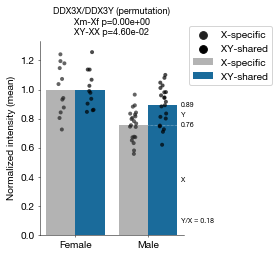

In [43]:
fig, ax = plot_xy_peptides(df, pmeta, 'DDX3X', 'DDX3Y', n_reps=1000)

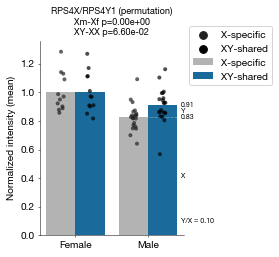

In [44]:
fig, ax = plot_xy_peptides(df, pmeta, 'RPS4X', 'RPS4Y1', n_reps=1000)

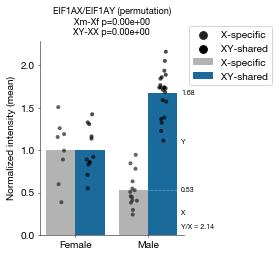

In [45]:
fig, ax = plot_xy_peptides(df, pmeta, 'EIF1AX', 'EIF1AY', n_reps=1000)

Now plot all three together with one million reps (warning: will take a few minutes to run)

RPS4X/RPS4Y1...
DDX3X/DDX3Y...
EIF1AX/EIF1AY...


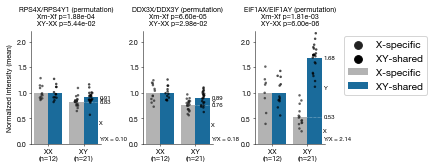

In [170]:
xgenes = ['RPS4X', 'DDX3X', 'EIF1AX']
ygenes = ['RPS4Y1', 'DDX3Y', 'EIF1AY']

fig, axes = plt.subplots(1, 3, figsize=(6, 2.5))
fig.subplots_adjust(wspace=0.6, top=0.75, right=0.75, left=0.07)
for i, (gx, gy, ax) in enumerate(zip(xgenes, ygenes, axes)):
    general._print("{0}/{1}...".format(gx, gy))
    
    fig, ax = plot_xy_peptides(df, pmeta, gx, gy, n_reps=1000000,
                               ax=ax, annotextsize=6)
    ax = pf.format_axis_labels(ax, ticklabsize=7, labsize=7)
    ax.set_ylim([0, 2.2])
    if i != 2:
        ax.legend_.remove()
    else:
        ax.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
    if i != 0:
        ax.set_ylabel('')
    ax.set_xticklabels(["XX\n(n=12)", "XY\n(n=21)"])
fig.savefig("{}/mass_spec_3xypairs.pdf".format(outdir))

Save normalized abundance data for XY pairs

In [46]:
df.to_csv("{}/xypairs_relative_protein_signal.txt".format(outdir), sep='\t')

#### Plot some control genes

Reformat original dataframe of protein abundances

In [47]:
dprot.head()

,gene_name,group_id,set1_peptides,set2_peptides,set3_peptides,total_peptides,Set1~rq_126_sn_scaled,Set1~rq_127a_sn_scaled,Set1~rq_127b_sn_scaled,Set1~rq_128a_sn_scaled,...,Set3~rq_127a_sn_scaled,Set3~rq_127b_sn_scaled,Set3~rq_128a_sn_scaled,Set3~rq_128b_sn_scaled,Set3~rq_129a_sn_scaled,Set3~rq_129b_sn_scaled,Set3~rq_130a_sn_scaled,Set3~rq_130b_sn_scaled,Set3~rq_131a_sn_scaled,Set3~rq_131b_sn_scaled
protein_id,,,,,,,,,,,,,,,,,,,,,
sp|A0AVT1|UBA6_HUMAN,UBA6,1165,8,11,8,27,8.91838,8.94995,9.21245,8.96610,...,9.59959,8.85613,7.95495,8.71231,9.98684,8.32241,9.63201,10.73070,9.31577,8.55993
sp|A0FGR8-2|ESYT2_HUMAN,ESYT2,1246,9,10,11,30,9.67071,9.69186,8.22506,10.53170,...,8.33588,9.37875,8.71900,8.38809,9.44621,8.38034,9.95310,10.10040,9.92534,8.66303
sp|A0M8Q6|LAC7_HUMAN,IGLC7,295,12,7,14,33,5.22069,9.24773,8.87117,16.93320,...,7.30741,7.01629,6.51712,9.28722,9.95747,8.57503,10.70910,5.48256,15.69480,8.98227
sp|A0PJW6|TM223_HUMAN,TMEM223,2891,2,2,0,4,9.66626,9.45501,9.38523,8.71914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp|A1A4S6|RHG10_HUMAN,ARHGAP10,2183,7,6,1,14,8.79586,10.62160,9.25684,8.22925,...,9.86637,9.98527,7.89259,9.92733,6.48916,11.54670,7.40060,9.34984,8.17158,8.90782


In [48]:
rqcols = list(filter(lambda c: 'rq' in c, dprot.columns))
rdata = dprot[['gene_name'] + rqcols]

# drop duplicates (e.g., alternative isoforms)
rdata = rdata.loc[~rdata.gene_name.duplicated()]

# save original uniprot ID
uniprot_map = rdata[['gene_name']].reset_index().set_index('gene_name')['protein_id']

rdata = rdata.set_index('gene_name')

_rdata = {}
for s in ('Set1', 'Set2', 'Set3'):
    scols = list(filter(lambda c: c.startswith(s), rdata.columns))
    r_s = rdata[scols].copy()
    r_s.columns = list(map(lambda s: s.split('~')[1].rsplit('_', 1)[0], r_s.columns))
    _rdata[s] = r_s.copy()
rdata = pd.concat(_rdata, axis=1, sort=True)
rdata

Set1                                                         \
          rq_126_sn rq_127a_sn rq_127b_sn rq_128a_sn rq_128b_sn rq_129a_sn   
gene_name                                                                    
A1BG        4.48146    8.32340    6.82231   12.32740   16.17220    7.46256   
A2M         6.49070   11.69840    9.37458   10.85410    9.63036    8.62219   
AACS        7.38181    8.39737    6.34746    9.50394    9.45693   12.07070   
AAGAB       9.20118    8.94465   10.10270    6.98044    7.44730    9.53550   
AAK1        9.47289    8.47153    9.26660    9.16390    8.77718    9.23940   
...             ...        ...        ...        ...        ...        ...   
ZPR1        8.73570    8.33948   10.26890    7.14625   11.35060    8.42280   
ZRANB2      9.01290    7.44542    7.90970   10.28570    9.52271   10.68190   
ZW10       10.37800    7.60166    9.29722    8.99975    8.07670    8.83275   
ZYX         9.05797    7.88403    9.36053    7.00087    6.92514   11.30220   
ZZEF1       9.99622    8.63826    9.73790    6.24690    8.22987    8.90848   

                                                       ...       Set3  \
          rq_129b_sn rq_130a_sn rq_130b_sn rq_131a_sn  ... rq_127a_sn   
gene_name                                              ...              
A1BG        10.69710   12.42900    4.82790    5.78120  ...   10.35880   
A2M          9.73662    7.99056    5.21216    7.67714  ...    9.14114   
AACS         8.57299   10.10610    6.36435   11.23380  ...    8.07036   
AAGAB       11.47750   10.50370    8.85952    8.44481  ...        NaN   
AAK1         8.54129    9.02386    9.26482    9.57990  ...    8.12933   
...              ...        ...        ...        ...  ...        ...   
ZPR1        12.36840   10.48050    8.08573    7.37141  ...    9.50874   
ZRANB2      10.66520    9.31180    9.11477    8.18537  ...    6.29345   
ZW10         8.80934    9.95367    9.32754    9.73662  ...    8.93572   
ZYX         11.60260   11.92740    7.85123    9.12212  ...    9.12406   
ZZEF1        7.17094   10.19780   10.27020   12.14880  ...    9.11917   

                                                                             \
          rq_127b_sn rq_128a_sn rq_128b_sn rq_129a_sn rq_129b_sn rq_130a_sn   
gene_name                                                                     
A1BG        11.03180    6.23707    9.35857    8.06476    8.23355    9.66792   
A2M         12.72560    7.53546    9.57889    8.57727    9.98707    4.94198   
AACS         9.50022    9.77494   10.48040   11.68180    8.08174   11.49930   
AAGAB            NaN        NaN        NaN        NaN        NaN        NaN   
AAK1        10.10410    7.20320   10.42670    8.35131    8.65902    8.44487   
...              ...        ...        ...        ...        ...        ...   
ZPR1         8.79291    8.83671    7.54691   11.24490    9.52327    9.30718   
ZRANB2       7.05020    9.80603    8.75941   10.49750    9.43960   12.34240   
ZW10         9.46754    8.87469    8.54994    9.13731    8.75650    9.28907   
ZYX          8.23957    7.09302    8.84135   10.82140    7.93827   11.67400   
ZZEF1        8.55912    7.58128   10.59000    9.34741    8.90931    9.87500   

                                            
          rq_130b_sn rq_131a_sn rq_131b_sn  
gene_name                                   
A1BG         6.43035   10.93370    7.36769  
A2M          8.45338    7.88106    5.93733  
AACS         9.14282    9.67079    5.84359  
AAGAB            NaN        NaN        NaN  
AAK1         9.46090    8.94204    9.11389  
...              ...        ...        ...  
ZPR1         8.47369    6.83782    9.91238  
ZRANB2       9.66906    9.35882    9.37804  
ZW10         9.53094    9.02847    8.93158  
ZYX         10.60360    7.26803    9.22672  
ZZEF1       10.82520    8.04457    8.63986  

[5023 rows x 33 columns]

Highly expressed genes that are subject to XCI (Balaton et al. 2015 Biol Sex Diff)

In [49]:
sgenes = ['SAT1', 'AK310094', 'NDUFB11', 'RBM3',
          'PIM2', 'PLP2', 'TSPYL2', 'UBQLN2', 'PGK1',
          'HNRNPH2', 'ARMCX3', 'TCEAL8', 'SLC25A5',
          'RNF113A', 'NDUFA1', 'GLUD2', 'FAM127A',
          'RBMX', 'SSR4', 'FLNA', 'EMD', 'RPL10', 'GDI1']
sgenes = list(filter(lambda s: s in rdata.index, sgenes))
sgenes

['NDUFB11',
 'RBM3',
 'PLP2',
 'UBQLN2',
 'PGK1',
 'HNRNPH2',
 'ARMCX3',
 'SLC25A5',
 'FAM127A',
 'RBMX',
 'SSR4',
 'FLNA',
 'EMD',
 'RPL10',
 'GDI1']

How many peptides detected?

In [50]:
n_peps.loc[sgenes].sort_values(ascending=False)

gene_name
PGK1       402
FLNA       314
SLC25A5    303
GDI1       122
NDUFB11     63
UBQLN2      32
RPL10       27
RBMX        18
EMD         15
FAM127A     10
HNRNPH2     10
ARMCX3       5
RBM3         4
SSR4         3
PLP2         3
Name: total_peptides, dtype: int64

Heart transcript expression level

In [51]:
heart_tpm.loc[sgenes]

NDUFB11    117.572490
RBM3        55.842746
PLP2        54.414508
UBQLN2      11.318279
PGK1        95.699652
HNRNPH2     36.366718
ARMCX3      23.626602
SLC25A5     89.946079
FAM127A    264.768392
RBMX        43.004613
SSR4        97.385273
FLNA        54.820537
EMD         36.069441
RPL10      886.850249
GDI1        53.270763
dtype: float64

Sort by heart transcript expression levels

In [52]:
sgenes = list(heart_tpm.loc[sgenes].sort_values(ascending=False).index)

Plot sex bias for top five genes

In [53]:
calc_normalized_signal(rdata, pmeta, 'RBMX')

,Normalized intensity,sex,set_id
rq_126_sn,0.909218,M,Set1
rq_127a_sn,0.788209,F,Set1
rq_127b_sn,0.933933,F,Set1
rq_128a_sn,0.993063,M,Set1
rq_128b_sn,0.787818,M,Set1
rq_129a_sn,1.050967,M,Set1
rq_129b_sn,1.183828,F,Set1
rq_130a_sn,1.094029,F,Set1
rq_130b_sn,0.998592,M,Set1
rq_131a_sn,0.882051,M,Set1


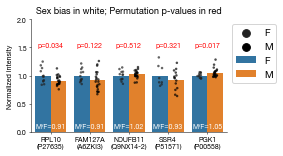

In [54]:
genes = [g for g in sgenes[:5]]

df = []
for g in genes:
    df_g = calc_normalized_signal(rdata, pmeta, g)
    df_g['gene'] = g
    df.append(df_g)
df = pd.concat(df, axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize=(4, 2.5))
fig.subplots_adjust(top=0.75, right=0.75, left=0.07)

ax = sns.barplot(x='gene', y='Normalized intensity', hue='sex', data=df,
                 order=genes, hue_order=['F', 'M'], ci=None)
ax = sns.stripplot(x='gene', y='Normalized intensity', hue='sex', data=df,
                   order=genes, hue_order=['F', 'M'], color='k', dodge=True,
                   alpha=0.7, s=2.5)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# add uniprot IDs
xtlabs = []
for lab in ax.get_xticklabels():
    t = uniprot_map[lab.get_text()].split('|')[1]
    xtlabs.append("{0}\n({1})".format(lab.get_text(), t))
ax.set_xticklabels(xtlabs, size=9)

# significance and ratio
for i, g in enumerate(genes):
    r_mf, R, p = get_permutation_pval(rdata, pmeta, g, n_reps=10000)
    t = 'p={:.3f}'.format(p)
    # p-value
    ax.text(i, 1.5, t, color='r', size=7, horizontalalignment='center')
    # MF ratio
    ax.text(i, 0.05, "M/F={:.2f}".format(r_mf), color='w', size=7,
            horizontalalignment='center', verticalalignment='bottom')

ax = pf.format_spines(ax)
ax = pf.format_axis_labels(ax, ticklabsize=7, labsize=7)
ax.set_xlabel('')
ax.set_title("Sex bias in white; Permutation p-values in red", size=9)

ax.set_ylim([0, 2.0])

fig.savefig("{}/XCIgenes_males_vs_females.pdf".format(outdir))